### Imports

In [1]:
%load_ext autoreload
%autoreload complete

### Tokenizing Text for Histogram and Word Cloud Analysis
To extract insight better, we remove useless stopwords and lemmatize the remaining words.

In [3]:
import pandas as pd

df = pd.read_csv(
    "/home/jh2xl/Code/sch-repos/AIDS-Project-2/data/youtube_flex tape/announcement/Rjc7d1yS4Y0.csv"
)

In [ ]:
import string
import re
import nltk
import html2text
from nltk.stem import WordNetLemmatizer

h = html2text.HTML2Text()
h.ignore_links = True
h.ignore_mailto_links = True
h.ignore_images = True
h.ignore_emphasis = True
h.ignore_tables = True

num_re = r"\b\d+\b"
spaces_re = r"\s+"
product_name = r"\bflex tape\b"

nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords.words("english")
punc_translate = str.maketrans(string.punctuation, " " * len(string.punctuation))
wnl = WordNetLemmatizer()


# TODO: Have a version that maintains original structure for ye olde sentiment analysis.
def tokenize(text):
    # HTML to plain
    text = h.handle(text)

    # Remove numbers
    text = re.sub(num_re, " ", text)
    # Remove punctuation
    text = text.translate(punc_translate)
    # Remove extra spaces
    text = re.sub(spaces_re, " ", text)
    text = text.strip()

    # Lowercase
    text = text.lower()

    # Remove certain words, like the product name itself.
    # Or also normalize names to their full form: i.e., obama -> barack obama
    text = re.sub(product_name, " ", text)

    # Remove extra spaces again.
    text = re.sub(spaces_re, " ", text)
    text = text.strip()
    
    # TODO: Do NER and other techniques to preserve hyphenated words and nouns.
    # Remove stopwords
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords]

    # Lemmatize
    tokens = [wnl.lemmatize(t) for t in tokens]

    # Filter empty and short tokens
    tokens = [t for t in tokens if len(t) > 2]
    return tokens

[nltk_data] Downloading package stopwords to /home/jh2xl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jh2xl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Tokenize all words.
df["tokenized"] = df["text"].apply(tokenize)

df.sample(1)

,id,videoId,parentId,isReply,authorName,authorId,text,likes,updatedAt,tokenized
304,Ugw99xsDId3XJoRaE_F4AaABAg,Rjc7d1yS4Y0,Ugw99xsDId3XJoRaE_F4AaABAg,False,@gormauslander,UCBHduFhNT6cDTb3tNE4YB6Q,When you have fully embraced meme status,0,2020-02-20T05:24:32Z,"[fully, embraced, meme, status]"


(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

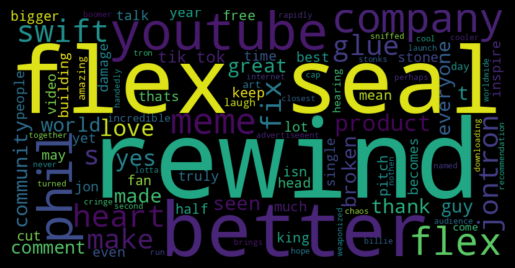

In [21]:
# Chain tokenized words across all rows into a single string for word cloud.
from wordcloud import WordCloud
from itertools import chain
import matplotlib.pyplot as plt

# Prefilters.
df2 = df
df2 = df2[~df2.isReply]  # Filter by if comment is reply.
df2 = df2[df2.likes > 100]  # Filter by likes.
df2 = df2[df2.text.str.len() > 20]  # Filter by text length.
# TODO: date filtering.
# df2 = df2[df2.updatedAt > "TODO"]  # Filter by JS-style date e.g., 2020-01-31T17:01:46Z
# TODO: compound/weighted filtering.

all_words = list(chain.from_iterable(df2["tokenized"].tolist()))
# NOTE: It supports collocations by default; so it will try and guess bigrams on its own.
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
wordcloud = WordCloud(
    width=800,
    height=400,
    max_words=100,
    mode="RGBA",

).generate("\t".join(all_words))


plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

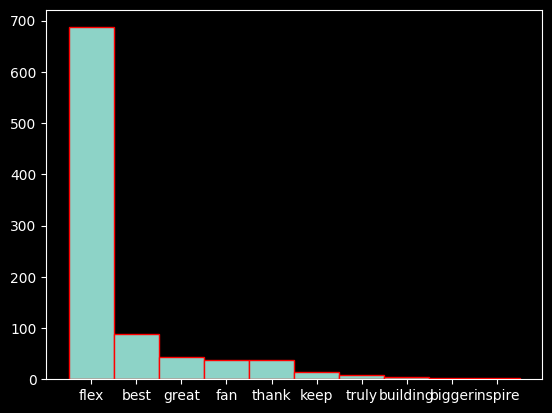

In [24]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import everygrams

# Prefilters.
df2 = df
df2 = df2[~df2.isReply]  # Filter by if comment is reply.
df2 = df2[df2.likes > 100]  # Filter by likes.
df2 = df2[df2.text.str.len() > 20]  # Filter by text length.
# TODO: date filtering.
# df2 = df2[df2.updatedAt > "TODO"]  # Filter by JS-style date e.g., 2020-01-31T17:01:46Z
# TODO: compound/weighted filtering.

max_lbl_len = 16
top_n = 10
n_gram = 1

freqs = Counter(
    [" ".join(s) for s in everygrams(chain.from_iterable(df["tokenized"].tolist()), max_len=n_gram)]
)
lbls, vals = zip(*freqs.items())

# Drop irrelevant words.

# Take top n words.
if len(lbls) > top_n:
    lbls = lbls[:top_n]
    vals = vals[:top_n]

# rearrange your data.
sort_idx = np.argsort(vals)[::-1]
lbls = np.array(lbls)[sort_idx]
vals = np.array(vals)[sort_idx]

# Trim really long labels with ellipses.
lbls = [l[:max_lbl_len-3] + "..." if len(l) > max_lbl_len else l for l in lbls]

indexes = np.arange(len(lbls))
plt.bar(indexes, vals, width=1.0, edgecolor="red")
plt.xticks(indexes, lbls)
plt.show()